In [ ]:
!pip install seaborn
!pip install lenskit
!pip install pandas
!pip install pySpark
!pip install torch
!pip install torchviz

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [3]:
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, Embedding, merge, Flatten, Dense, Dropout, Dot, Activation, Concatenate, Lambda
 
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K

from lenskit import batch, util
from lenskit import crossfold as xf
from lenskit.algorithms import funksvd
from lenskit.metrics.predict import rmse

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType


In [4]:
!git clone https://github.com/HaykInanc/move_data.git 

ratings = pd.read_csv('/content/move_data/ratings.csv') #ПользовательId-фильмId-рейтинг
movies = pd.read_csv('/content/move_data/movies.csv') #ФильмId-название-жанры

fatal: destination path 'move_data' already exists and is not an empty directory.


In [5]:
n_users  = ratings.userId.nunique() #Число уникальных пользователей
n_movies = ratings.movieId.nunique() #Число уникальных фильмов

In [6]:
#Функция для смены userId и movieId в базовых таблицах на последовательные, начинающиеся с 0.
#
def data_preparation(movies, ratings):
  
    uniq_users = ratings.userId.unique()
    uniq_movies = ratings.movieId.unique()

    #Таблица movie избыточна, удалим далее неоцененные фильмы
    id_rated_films = uniq_movies
    id_not_rated_films = [x for x in movies['movieId'] if x not in id_rated_films]

    if len(id_not_rated_films) !=0:
        id_fields_not_rated_films_in_movie = [movies[movies['movieId'] == i].index[0] for i in id_not_rated_films]
        movies = movies.drop(id_fields_not_rated_films_in_movie)

    #Словари соответствия старого индекса новому
    useridtoidx = {o:i for i,o in enumerate(uniq_users)} 
    movieidtoidx= {o:i for i,o in enumerate(uniq_movies)}

    ratings.userId = ratings.userId.apply(lambda x:useridtoidx[x])
    ratings.movieId = ratings.movieId.apply(lambda x:movieidtoidx[x])
    movies.movieId = movies.movieId.apply(lambda x:movieidtoidx[x])

    movie_names = movies.set_index('movieId')['title'].to_dict()

    return movies, ratings, movie_names
 

In [7]:
#print("Было: \n", ratings.head())
movies, ratings, movie_names = data_preparation(movies, ratings)
#print("Стало: \n", ratings.head())
#print(movies.head())
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'movie'})
ratings = ratings.rename(columns={'movieId': 'movie'})

In [8]:
#Разделение на тренировочную и обучающую выборку
data = []

for train, test in xf.partition_users(ratings, 1, xf.SampleFrac(0.2)):
    data.append(train)
    data.append(test)

# Keras

In [9]:
X_train_k = [data[0]['user'].values, data[0]['movie'].values]
Y_train_k = data[0]['rating'].values

X_test_k = [data[1]['user'].values, data[1]['movie'].values]
Y_test_k = data[1]['rating'].values

In [10]:
n_users  = ratings.user.max()+1
n_movies = ratings.movie.max()+1

n_hid_layer = 50 #размерность в embed

In [11]:
#Функция ошибки 
def my_RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [12]:
def model_rec_system(n_users, n_movies, n_hid_layer):
    user = Input(shape=(1,))
    l_user = Embedding(n_users, n_hid_layer, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    l_user = Flatten()(l_user)

    movie = Input(shape=(1,))
    l_movie = Embedding(n_movies, n_hid_layer, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    l_movie = Flatten()(l_movie)

    x = Dot(axes=1)([l_user, l_movie])
    x = Dropout(0.05)(x)
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)

    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x) #масштабирование

    model = Model(inputs=[user, movie], outputs=x)
    
    opt = Adam(lr=0.0001)
    model.compile(loss=my_RMSE, optimizer=opt)
    return model

max_rating = 5 #ограничивающие оценку значения
min_rating = 0
model_keras = model_rec_system(n_users, n_movies, n_hid_layer)
#plot_model(model_keras, to_file='model.png') #Неудобно, очень большая


In [13]:
def train_model(n_epoch = 1):
  history = model_keras.fit(x=X_train_k, y=Y_train_k, batch_size=32, epochs=n_epoch, validation_data=(X_test_k, Y_test_k))    
  print("Mean RMSE:", np.mean(history.history['val_loss']))
  return history

history = train_model(10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2501/2501 [==============================] - 11s 5ms/step - loss: 1.0957 - val_loss: 0.9394
Epoch 2/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.9169 - val_loss: 0.8557
Epoch 3/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.8628 - val_loss: 0.8534
Epoch 4/10
2501/2501 [==============================] - 11s 5ms/step - loss: 0.8267 - val_loss: 0.8456
Epoch 5/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.7688 - val_loss: 0.8296
Epoch 6/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.7015 - val_loss: 0.8084
Epoch 7/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.6544 - val_loss: 0.7937
Epoch 8/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.6163 - val_loss: 0.7826
Epoch 9/10
2501/2501 [==============================] - 11s 5ms/step - loss: 0.5890 - val_loss: 0.7759
Epoch 10/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.5670

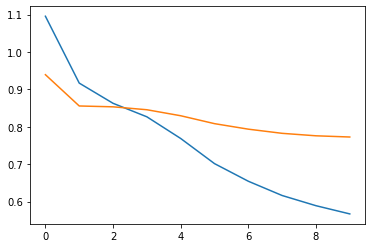

In [14]:
x = range(10)
plt.plot(x, history.history['loss'], x, history.history['val_loss'])

# Pytorch



In [15]:
class ReplaysDataSet(Dataset):
    def __init__(self, x, y):
        self.x_data = x
        self.y_data = y
        self.length = len(self.y_data)
  
    def __getitem__(self, index):
        return [torch.tensor(self.x_data[0][index].item()), torch.tensor(self.x_data[1][index].item())], self.y_data[index]
    def __len__(self):
        return self.length

In [16]:
X_train_p = [torch.tensor(data[0]['user'].values.tolist()), torch.tensor(data[0]['movie'].values.tolist())]
Y_train_p = torch.tensor(data[0]['rating'].values.tolist()).view(-1,1)

X_test_p = [torch.tensor(data[1]['user'].values.tolist()), torch.tensor(data[1]['movie'].values.tolist())]
Y_test_p = torch.tensor(data[1]['rating'].values.tolist()).view(-1,1)

In [17]:
#разделение на батчи
dataset = ReplaysDataSet(X_train_p, Y_train_p)
trainLoader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [18]:
criterion = nn.MSELoss()

In [19]:
class model_rec_system(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        n_fich = 50
        self.eu = nn.Embedding(n_users, n_fich)
       
        self.em = nn.Embedding(n_movies, n_fich)

        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_fich, 10)
        
        # layer 2 fully connected 50 units # 1
        self.lin2 = nn.Linear(10, 1)
        
        # dropouts
        self.drop1 = nn.Dropout(0.6)
        self.drop2 = nn.Dropout(0.5)
        
    def forward(self, data2):
        users1 = data2[0]
        users1 = torch.flatten(self.eu(users1), 1)

        movies2 = data2[1]
        movies2 =  torch.flatten(self.em(movies2), 1)

        x = torch.mul(users1, movies2)

        x = self.drop1(x)
        x = self.drop2(F.relu(self.lin1(x)))
        
        # output
        x = torch.sigmoid(self.lin2(x)) * (max_rating-min_rating) + min_rating

        return x

#ограничивающие оценку значения
max_rating = 5 
min_rating = 0

device = torch.device('cuda') if torch.cuda.is_available()  else torch.device('cpu')
model_pytorch = model_rec_system(n_users, n_movies)

optimizer = torch.optim.Adam(model_pytorch.parameters(), lr=5e-3, weight_decay=1e-5)

In [20]:
n_epoch = 10

train_losses = []
val_losses = []

for epoch in range(n_epoch):
    totalLoss = 0
    totalCorrect = 0
    model_pytorch = model_pytorch.train()
    
    for batch in trainLoader:
        x_train, y_train = batch
        optimizer.zero_grad()
        prediction = model_pytorch(x_train)
        loss = torch.sqrt(criterion(prediction, y_train)) #RMSE
        totalLoss += loss.item()
        loss.backward()
        optimizer.step()

    totalLoss = totalLoss/len(trainLoader)
    train_losses.append(totalLoss)

    model_pytorch = model_pytorch.eval()
    y_pred = model_pytorch(X_test_p)
    
    val_loss = torch.sqrt(criterion(y_pred, Y_test_p)).item()
    val_losses.append(val_loss)

    print('epoch: ', epoch,' loss: ', totalLoss)
    print('val_loss: ', val_loss)

epoch:  0  loss:  1.0479339881927097
val_loss:  1.0434297323226929
epoch:  1  loss:  1.0105830043470894
val_loss:  1.002437949180603
epoch:  2  loss:  0.9862638682853885
val_loss:  0.9892602562904358
epoch:  3  loss:  0.9715122327786453
val_loss:  0.9920976758003235
epoch:  4  loss:  0.9567521363437199
val_loss:  0.974362313747406
epoch:  5  loss:  0.9405345419605747
val_loss:  0.970072329044342
epoch:  6  loss:  0.9242197753476505
val_loss:  0.9657882452011108
epoch:  7  loss:  0.9085414660115186
val_loss:  0.9630289673805237
epoch:  8  loss:  0.9004754065776148
val_loss:  0.9639484286308289
epoch:  9  loss:  0.8939525934635568
val_loss:  0.9602826833724976


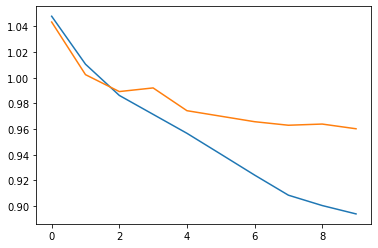

In [21]:
x = range(10)
plt.plot(x, train_losses, x, val_losses)

# Результаты

In [22]:
# Проверим рекомендации пользователя с id = 3
user_id = 3
chek_films = [] #Фильмы, которые оценил пользователь

for i in range(len(ratings.user)):
    if ratings.user[i] == 3:
        chek_films.append([ratings.movie[i],ratings.rating[i] ])

In [23]:
def keyFunc(item):
   return item[1]


chek_films.sort(key=keyFunc, reverse = True)

for i in chek_films[:10]:
  print(movie_names[i[0]], i[1])

#Выведен список из первых 5 фильмов, которые пользователь оценил на 5

Babe (1995) 5.0
Rumble in the Bronx (Hont faan kui) (1995) 5.0
Birdcage, The (1996) 5.0
Star Wars: Episode IV - A New Hope (1977) 5.0
Pulp Fiction (1994) 5.0
Clear and Present Danger (1994) 5.0
Forrest Gump (1994) 5.0
Four Weddings and a Funeral (1994) 5.0
Lion King, The (1994) 5.0
Jurassic Park (1993) 5.0


In [34]:
id_chek_films = []
for i in chek_films:
  id_chek_films.append(i)

In [35]:
not_chek_films = [x for x in range(n_movies) if x not in id_chek_films]

In [36]:
#Выведем топ-5 фильмов из первой сотни, которые, согласно моделям, больше всего понравятся пользователю 3 

In [37]:
def top_n_keras_model(n_films):
  pred_films = []
  for i in not_chek_films[:100]:   #Проверим первые 100 фильмов
    p = model_keras.predict([np.array([1]), np.array([i])])
    pred_films.append([i, p[0][0]])

  pred_films.sort(key=keyFunc, reverse = True)

  for i in pred_films[:n_films]:
    print(movie_names[i[0]], i[1])


def top_n_pytorch_model(n_films):
  pred_films = []
  for i in not_chek_films[:100]:   #Проверим первые 100 фильмов
    p = model_pytorch([torch.tensor([1]), torch.tensor([i])])
    pred_films.append([i, p[0][0].item()])

  pred_films.sort(key=keyFunc, reverse = True)

  for i in pred_films[:n_films]:
    print(movie_names[i[0]], i[1])


In [38]:
top_n_keras_model(10)

Shawshank Redemption, The (1994) 4.122558
Pulp Fiction (1994) 4.0831037
Usual Suspects, The (1995) 4.0636973
Remains of the Day, The (1993) 4.0234385
Brady Bunch Movie, The (1995) 4.0219955
Like Water for Chocolate (Como agua para chocolate) (1992) 4.0196137
Dances with Wolves (1990) 4.0054173
Tron (1982) 3.9941895
Circle of Friends (1995) 3.9926534
Schindler's List (1993) 3.987667


In [39]:
top_n_pytorch_model(10)

Apollo 13 (1995) 4.504985332489014
Schindler's List (1993) 4.301494598388672
Silence of the Lambs, The (1991) 4.207151889801025
Batman (1989) 4.197833061218262
Shawshank Redemption, The (1994) 4.1825971603393555
Like Water for Chocolate (Como agua para chocolate) (1992) 4.124320030212402
Terminator 2: Judgment Day (1991) 4.117629051208496
Little Women (1994) 4.103888988494873
Dances with Wolves (1990) 4.072399139404297
Remains of the Day, The (1993) 4.025836944580078
